# Caltech AI & Machine Learning Bootcamp

#### Capstone Project
#### CB AIML JAN 2024 COHORT 2
#### Student: Eric Michel
July 6, 2024

# Object Detection for Autonomous Driving Using Supervised Machine Learning



## Project Statement:
Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road 
transport. Automatic detection of vehicles on the road in real-time helps AV technology 
and makes ITS more intelligent in terms of vehicle tracking, vehicle counting, and road 
incident response.

## Goal
To Develop an AI model using a deep learning framework that predicts the type of vehicle present in an image as well as localizing the vehicle by rectangular bounding box.


Content:
1. Files and dataset structuring
2. Data Preparation of the dataset for model training.
3. Create a CNN architecture for object detection of your choice to train an object detection 
model. 
Algorithm or architecture selection is a very important aspect of ML model training, and we must pick the one that works the best for our dataset.
4. Evaluate the model and check the test results.
5. Run inferences on sample images and see if vehicles are detected accurately.


# Initialization

In [1]:
# !pip install pandas
# !pip install opencv-python

# !pip install tensorflow
# !pip install keras
# !pip install split-folders

# !pip install pydot


In [2]:
import os
import cv2
import pandas as pd
import numpy as np

import pathlib

import matplotlib.pyplot as plt
import PIL

from tqdm.notebook import tqdm

import tensorflow as tf
# from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.utils import plot_model

2024-08-20 02:09:20.262398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory Data Analysis (EDA)

### Load Images and Labels

In [3]:

# Define paths
data_dir = pathlib.Path("./Datasets")

images_dir = './Datasets/Images/'
annotation_path = './Datasets/Annotations/labels.csv'


In [4]:

# Load the labels from labels.csv
labels_df = pd.read_csv(annotation_path, sep=',', header=None)
labels_df.columns = ['image_id', 'label', 'x_min', 'y_min', 'x_max', 'y_max']

In [5]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351549 entries, 0 to 351548
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  351549 non-null  int64 
 1   label     351549 non-null  object
 2   x_min     351549 non-null  int64 
 3   y_min     351549 non-null  int64 
 4   x_max     351549 non-null  int64 
 5   y_max     351549 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 16.1+ MB


In [6]:
# See the first 8 labes from the data
labels_df.head(8)

,image_id,label,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45
5,1,bus,205,155,568,314
6,1,bus,285,123,477,168
7,1,car,544,162,617,193


Image paths:  [PosixPath('Datasets/Images/00000000.jpg'), PosixPath('Datasets/Images/00000001.jpg'), PosixPath('Datasets/Images/00000002.jpg'), PosixPath('Datasets/Images/00000003.jpg'), PosixPath('Datasets/Images/00000004.jpg'), PosixPath('Datasets/Images/00000005.jpg'), PosixPath('Datasets/Images/00000006.jpg'), PosixPath('Datasets/Images/00000007.jpg'), PosixPath('Datasets/Images/00000008.jpg'), PosixPath('Datasets/Images/00000009.jpg'), PosixPath('Datasets/Images/00000010.jpg'), PosixPath('Datasets/Images/00000011.jpg'), PosixPath('Datasets/Images/00000012.jpg'), PosixPath('Datasets/Images/00000013.jpg'), PosixPath('Datasets/Images/00000014.jpg'), PosixPath('Datasets/Images/00000015.jpg'), PosixPath('Datasets/Images/00000016.jpg'), PosixPath('Datasets/Images/00000017.jpg'), PosixPath('Datasets/Images/00000018.jpg'), PosixPath('Datasets/Images/00000019.jpg'), PosixPath('Datasets/Images/00000020.jpg'), PosixPath('Datasets/Images/00000021.jpg'), PosixPath('Datasets/Images/00000022.jpg

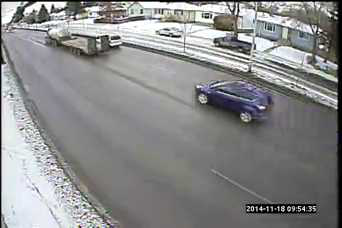

In [7]:


#Load image paths
images_pool = list(data_dir.glob('*/*.jpg'))
images_pool = sorted(images_pool)
print("Image paths: ",images_pool)
print("Image count: ",len(images_pool))

# Show image from first path
PIL.Image.open(str(images_pool[0]))

## Dataset labeling overview

In [8]:
# Get the number of classes in the labeled data
unique_labels = labels_df['label'].unique()
len(unique_labels)

11

In [9]:
labels_df['label'].value_counts()

label
car                      233497
pickup_truck              44283
motorized_vehicle         25845
bus                       10598
articulated_truck          9301
work_van                   8709
pedestrian                 7128
single_unit_truck          5741
non-motorized_vehicle      2350
bicycle                    2260
motorcycle                 1837
Name: count, dtype: int64

Observation: We notice a low underrepresentation for label 'motorcycle' and oversampling of 'car'

## See sample images containing at least one vehicle from each class

In [10]:
# Group by 'label' and get the first occurrence in each label
first_occurrences = labels_df.groupby('label', as_index=False).first()

print(first_occurrences)

                    label  image_id  x_min  y_min  x_max  y_max
0       articulated_truck         0     43     25    109     55
1                 bicycle        73     84    376    237    470
2                     bus         1    205    155    568    314
3                     car         0    194     78    273    122
4              motorcycle       257    188    340    233    418
5       motorized_vehicle         2    334    362    603    479
6   non-motorized_vehicle       132    165     31    315    116
7              pedestrian        47    266     46    283     72
8            pickup_truck         0    213     34    255     50
9       single_unit_truck        26    163     40    216     68
10               work_van        15    115     79    247    154


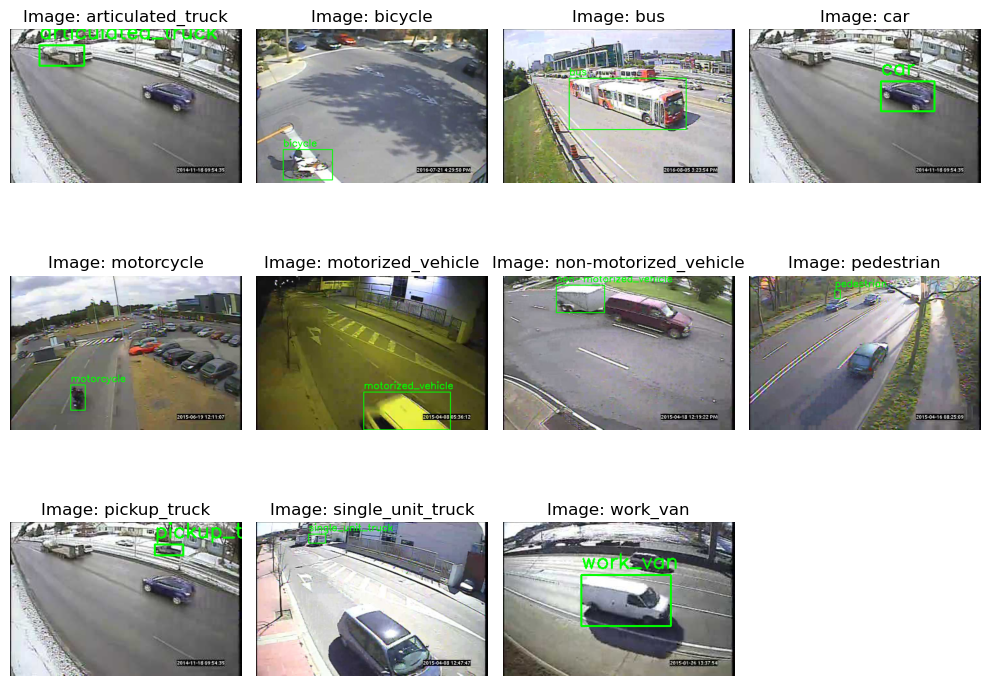

In [11]:


plt.figure(figsize=(10, 10))
for index, row in first_occurrences.iterrows():    

    img_path = os.path.join(images_dir, f"{row['image_id']:08}.jpg")
    # print(img_path)
    
    img_text = row['label']
     
    image = cv2.imread(img_path)
    # Convert the image from BGR to RGB format for correct color representation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Bounding boxes
    x1, y1, x2, y2 = row['x_min'], row['y_min'], row['x_max'], row['y_max']
    label = row['label'] 
    color = (0, 255, 0)  # Green color
    # Draw the bounding boxes
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    # Put the label text near the bounding box
    cv2.putText(image, img_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    

    # Display the image with bounding boxes and labels
    # plt.figure(figsize=(10, 10))
    plt.subplot(4, 4, index+1)
        
    plt.imshow(image)
    plt.title(f'Image: {img_text}')
    
    plt.axis('off')
 

plt.tight_layout()
plt.show()

## Load Label and Images & Scale Bounding Boxes and Images

In [12]:

# New image dimensions for image resizing
new_width, new_height = 224, 224

### Load Image Path For Each Label

We will have as many image paths as labels exists

In [13]:
# Load images from labeled data and store in array
image_data = []
image_paths = []


# Limit the number of images in this project to avoid long computation times
labels_df = labels_df.iloc[:1000]
len(labels_df)

1000

In [14]:
labels_df['label'].value_counts()

label
car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: count, dtype: int64

In [15]:

scaled_boxes = labels_df.copy()

generator = labels_df.iterrows()

# I use tqdm to monitor the progress of the loop
for index, row in tqdm(generator, total=len(labels_df)):    
    img_path = os.path.join(images_dir, f"{row['image_id']:08}.jpg")
    # print(img_path)
    
    img = cv2.imread(img_path)
        
    if img is not None:
        image_data.append(img)
        image_paths.append(img_path)
        
        # Original image dimensions
        original_height, original_width = img.shape[:2]
        
        # Calculate the Scaling Factor
        width_scale = new_width / original_width
        height_scale = new_height / original_height
        
        # Adjust bounding boxes
        scaled_boxes.loc[index, 'x_min'] = int(row['x_min'] * width_scale)
        scaled_boxes.loc[index, 'y_min'] = int(row['y_min'] * height_scale)
        scaled_boxes.loc[index, 'x_max'] = int(row['x_max'] * width_scale)
        scaled_boxes.loc[index, 'y_max'] = int(row['y_max'] * height_scale)
        
    else:
        print(f"Error loading image: {img_path}")


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# See the first 8 labes from the data
labels_df.head(8)
print(labels_df)

# scaled_boxes=scaled_boxes.astype(int)
scaled_boxes.head(8)
print(scaled_boxes)
    

     image_id              label  x_min  y_min  x_max  y_max
0           0       pickup_truck    213     34    255     50
1           0                car    194     78    273    122
2           0                car    155     27    183     35
3           0  articulated_truck     43     25    109     55
4           0                car    106     32    124     45
..        ...                ...    ...    ...    ...    ...
995       306  motorized_vehicle     36     44     55     56
996       306                car    110     93    208    140
997       306  articulated_truck     55     19    111     37
998       307                car      2    233     17    283
999       307           work_van     75     46    115     73

[1000 rows x 6 columns]
     image_id              label  x_min  y_min  x_max  y_max
0           0       pickup_truck    139     33    167     49
1           0                car    127     76    178    119
2           0                car    101     26    119     34

In [17]:
type(image_data)

list

In [18]:
# See data from first image
image_data[0]

array([[[ 24,  24,  24],
        [ 17,  17,  17],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  2,   2,   2]],

       [[  0,   0,   0],
        [ 32,  32,  32],
        [ 55,  55,  55],
        ...,
        [  3,   3,   3],
        [  2,   2,   2],
        [  2,   2,   2]],

       [[ 34,  34,  34],
        [130, 130, 130],
        [199, 199, 199],
        ...,
        [  7,   7,   7],
        [  3,   3,   3],
        [  2,   2,   2]],

       ...,

       [[  4,   7,   5],
        [ 88,  91,  89],
        [148, 152, 147],
        ...,
        [  5,   5,   5],
        [  1,   1,   1],
        [  2,   2,   2]],

       [[  2,   5,   3],
        [ 87,  90,  88],
        [148, 152, 147],
        ...,
        [  5,   5,   5],
        [  0,   0,   0],
        [  2,   2,   2]],

       [[  3,   6,   4],
        [ 89,  92,  90],
        [146, 150, 145],
        ...,
        [  4,   4,   4],
        [  0,   0,   0],
        [  2,   2,   2]]

### Resize images

To ensure that the bounding boxes are valid for the resized images, we need to scale the bounding box coordinates according to the resizing factor applied to the images. 

In [19]:
if len(image_data) > 0:
    
    scaled_images = [cv2.resize(img, (new_width, new_height)) for img in image_data]
    
    scaled_images = np.array(scaled_images)
    print("Images resized successfully.")    

scaled_images.shape

Images resized successfully.


(1000, 224, 224, 3)

In [20]:
# Preview Sample Images
scaled_images[0]


array([[[ 22,  22,  22],
        [  4,   4,   4],
        [  5,   5,   5],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[ 10,  10,  10],
        [ 54,  54,  54],
        [ 73,  73,  73],
        ...,
        [ 11,  11,  11],
        [  3,   3,   3],
        [  2,   2,   2]],

       [[ 58,  58,  58],
        [185, 185, 185],
        [216, 216, 216],
        ...,
        [ 23,  23,  23],
        [  6,   6,   6],
        [  2,   2,   2]],

       ...,

       [[ 26,  29,  27],
        [135, 139, 135],
        [156, 159, 155],
        ...,
        [ 30,  30,  30],
        [  4,   4,   4],
        [  2,   2,   2]],

       [[ 24,  27,  25],
        [135, 139, 134],
        [160, 163, 158],
        ...,
        [ 29,  29,  29],
        [  4,   4,   4],
        [  1,   1,   1]],

       [[ 25,  28,  26],
        [134, 138, 133],
        [158, 161, 156],
        ...,
        [ 27,  27,  27],
        [  3,   3,   3],
        [  1,   1,   1]]

# Display Images

### Create a color map for each label

In [21]:
unique_labels

array(['pickup_truck', 'car', 'articulated_truck', 'bus',
       'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian',
       'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [22]:
# Define colors (using RGB tuple format)
# Define a list of primary and vivid colors in RGB format
primary_vivid_colors = [
    (255, 0, 0),    # Red
    (255, 255, 0),  # Yellow
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 0, 255),  # Pink
    (0, 255, 255),   # Cyan
     (128, 0, 128),  # Purple
    (255, 128, 0),  # Orange
    (0, 128, 0),    # Grass
    (128, 0, 0),    # Wine
    (128, 128, 0),  # Olive
    (0, 0, 128)    # Night Blue
]

# Ensure there are enough colors for all labels
if len(unique_labels) > len(primary_vivid_colors):
    raise ValueError(f"Not enough colors ({len(primary_vivid_colors)}) for the number of unique labels ({len(unique_labels)}).")

# Create a color mapping dictionary for each unique label
color_map = {label: primary_vivid_colors[i] for i, label in enumerate(unique_labels)}
color_map

{'pickup_truck': (255, 0, 0),
 'car': (255, 255, 0),
 'articulated_truck': (0, 255, 0),
 'bus': (0, 0, 255),
 'motorized_vehicle': (255, 0, 255),
 'work_van': (0, 255, 255),
 'single_unit_truck': (128, 0, 128),
 'pedestrian': (255, 128, 0),
 'bicycle': (0, 128, 0),
 'non-motorized_vehicle': (128, 0, 0),
 'motorcycle': (128, 128, 0)}

### Show Original Images

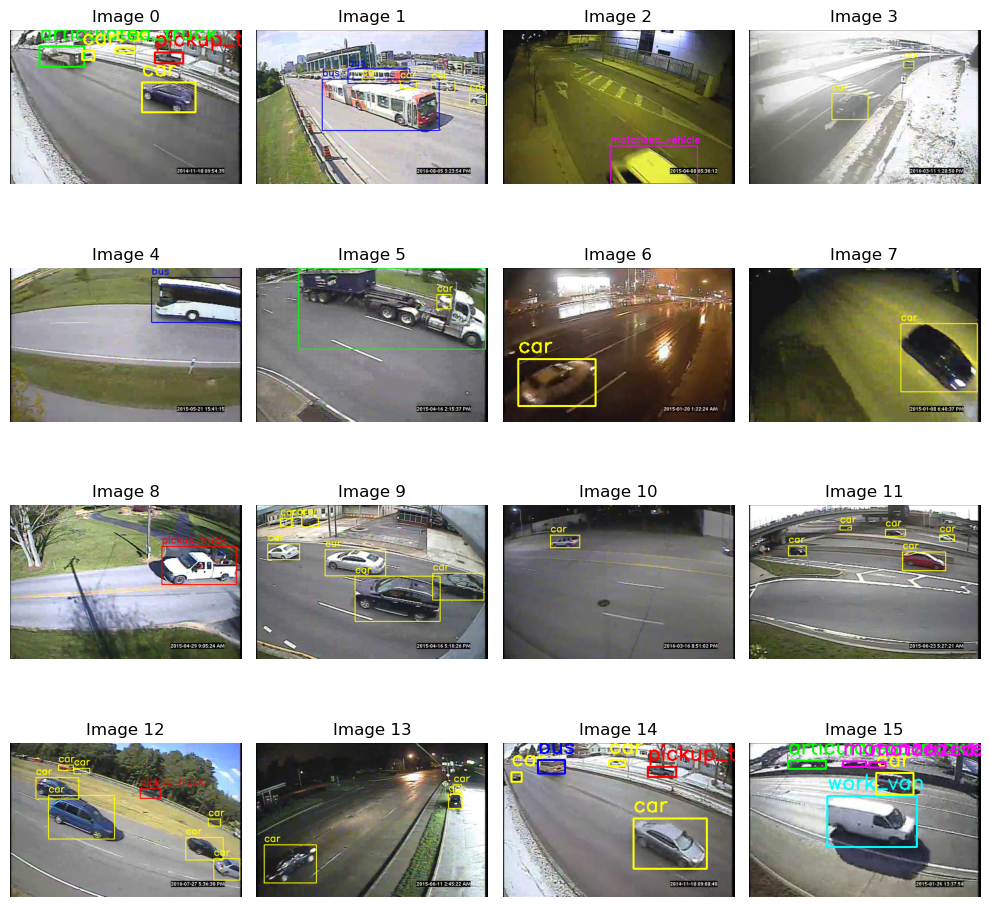

In [23]:

# Limit the number of images to 100 for easy test
# images_pool = images_pool.iloc[:10]
see_images = 16
img_num = 0 #index for images

plt.figure(figsize=(10, 10))
# plt.title(f'Surveillance Images')

for img in images_pool[:see_images]: 
    
    # Read the image using OpenCV
    image = cv2.imread(img)
    
    # Convert the image from BGR to RGB format for correct color representation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Retrieve labels and boxes for the image
    image_labels_boxes = labels_df[labels_df["image_id"] == img_num]
    
    # Draw bounding boxes and labels on the image
    for index, row in image_labels_boxes.iterrows():
        x1, y1, x2, y2 = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        label = row['label']
        
        #color = (0, 255, 0)  # Green color
        # Get the color for the current label from the color map
        color = color_map[label]

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Put the label text near the bounding box
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
     
    img_num += 1
      
    # Display the image with bounding boxes and labels
    plt.subplot(4, 4, img_num)
    plt.imshow(image)
    plt.title(f'Image {img_num-1}')
    
    plt.axis('off')
 

plt.tight_layout()
plt.show()

### Show A Sample Scaled Image with Boxes and Labels

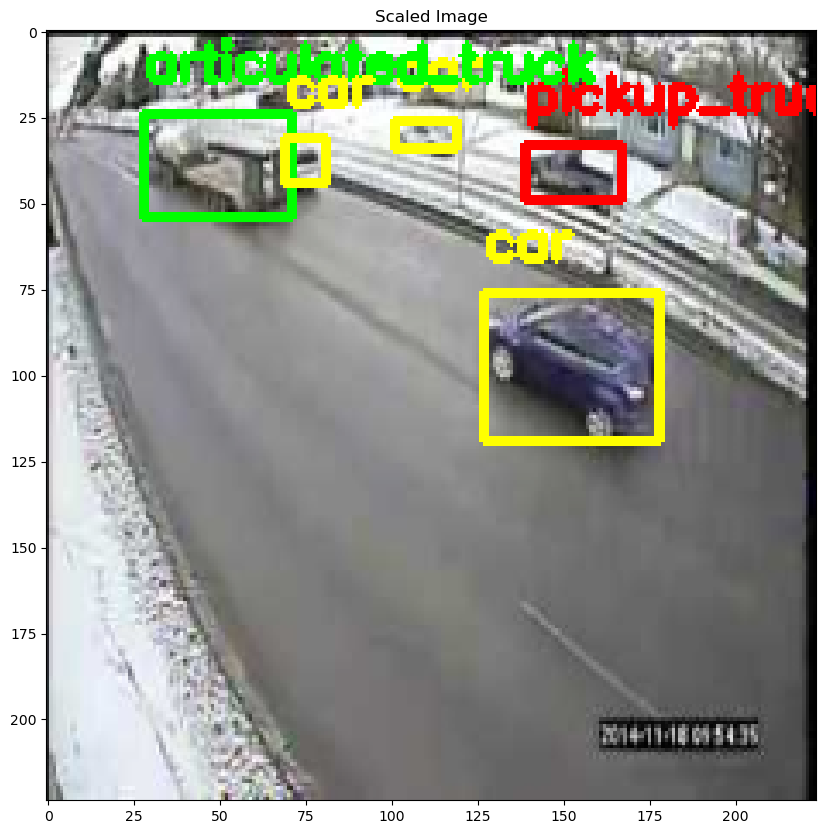

In [24]:
#Image to be displayed from the list
show_img = 0

# Display the first 16 resized images in a 4x4 grid
plt.figure(figsize=(10, 10))
plt.title(f'Scaled Image')

# Convert the image from BGR to RGB format for correct color representation
img_rgb = cv2.cvtColor(scaled_images[show_img], cv2.COLOR_BGR2RGB)

# Retrieve labels and boxes for the image
image_labels_boxes = scaled_boxes[scaled_boxes["image_id"] == show_img]

# Draw bounding boxes and labels on the image
for index, row in image_labels_boxes.iterrows():
    x1, y1, x2, y2 = row['x_min'], row['y_min'], row['x_max'], row['y_max']
    label = row['label']
    
    #color = (0, 255, 0)  # Green color
    # Get the color for the current label from the color map
    color = color_map[label]

    # Draw the bounding box
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
    
    # Put the label text near the bounding box
    cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


# Display the image
plt.imshow(img_rgb)

# # Turn off axis labels
# plt.axis('off')

# Display the figure
plt.show()

## Process Labels and Bounding Boxes

In [25]:
labels = labels_df['label'].to_numpy()
labels

array(['pickup_truck', 'car', 'car', 'articulated_truck', 'car', 'bus',
       'bus', 'car', 'car', 'car', 'car', 'motorized_vehicle', 'car',
       'car', 'bus', 'car', 'articulated_truck', 'car', 'car',
       'pickup_truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car',
       'car', 'car', 'car', 'car', 'car', 'car', 'car', 'pickup_truck',
       'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car',
       'car', 'bus', 'car', 'car', 'pickup_truck', 'articulated_truck',
       'work_van', 'motorized_vehicle', 'car', 'motorized_vehicle', 'car',
       'car', 'car', 'articulated_truck', 'car', 'car', 'car', 'car',
       'car', 'bus', 'bus', 'car', 'motorized_vehicle', 'car', 'car',
       'car', 'car', 'motorized_vehicle', 'pickup_truck', 'car',
       'pickup_truck', 'car', 'car', 'pickup_truck', 'car', 'car', 'car',
       'car', 'single_unit_truck', 'single_unit_truck', 'car',
       'pickup_truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car',
       'car', 'car',

### Convert labels to one-hot encoding

In [26]:
len(unique_labels)

11

In [27]:
# Convert labels to indices
label_to_index = {label: index for index, label in enumerate(unique_labels)}
# index_to_label = {index: label for index, label in enumerate(unique_labels)}
processed_labels = np.array([label_to_index[label] for label in labels])
processed_labels

array([ 0,  1,  1,  2,  1,  3,  3,  1,  1,  1,  1,  4,  1,  1,  3,  1,  2,
        1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  0,  2,  5,
        4,  1,  4,  1,  1,  1,  2,  1,  1,  1,  1,  1,  3,  3,  1,  4,  1,
        1,  1,  1,  4,  0,  1,  0,  1,  1,  0,  1,  1,  1,  1,  6,  6,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  0,  1,
        1,  6,  1,  1,  0,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  4,  1,  5,  1,  1,  3,  1,  1,  1,  5,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  4,  7,  1,  1,  4,  1,  0,  1,  1,
        0,  1,  1,  1,  1,  1,  4,  1,  0,  0,  5,  0,  0,  1,  0,  1,  1,
        1,  4,  1,  4,  0,  1,  4,  0,  0,  1,  1,  5,  2,  4,  1,  0,  1,
        1,  0,  1,  0,  1,  1,  4,  1,  1,  1,  0,  0,  1,  0,  5,  1,  1,
        0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  2,  1,  1,  1,
        1,  1,  1,  1,  1

In [28]:

# # Convert labels to one-hot encoding (if want categorical crossentropy Loss)
# enc_labels = to_categorical(processed_labels, num_classes=len(unique_labels))
# enc_labels

In [29]:
len(processed_labels)

1000

In [30]:
scaled_boxes.head(8)

,image_id,label,x_min,y_min,x_max,y_max
0,0,pickup_truck,139,33,167,49
1,0,car,127,76,178,119
2,0,car,101,26,119,34
3,0,articulated_truck,28,24,71,54
4,0,car,69,31,81,44
5,1,bus,63,72,176,146
6,1,bus,88,57,148,78
7,1,car,169,75,191,90


In [31]:
# bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
bounding_boxes = scaled_boxes[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
bounding_boxes

array([[139,  33, 167,  49],
       [127,  76, 178, 119],
       [101,  26, 119,  34],
       ...,
       [ 36,  18,  72,  36],
       [  0, 108,   5, 132],
       [ 23,  21,  35,  34]])

In [32]:
# Make sure all data is in array form
images = np.array(scaled_images)
bboxes = np.array(bounding_boxes)
processed_labels = np.array(processed_labels)

# Check the shape data for consistency
print("Shape of images:", images.shape)
print("Shape of bboxes:", bboxes.shape)
print("Shape of labels:", processed_labels.shape)


Shape of images: (1000, 224, 224, 3)
Shape of bboxes: (1000, 4)
Shape of labels: (1000,)


# Create the Model with CNN Architecture

In [33]:
# Check the version of Tensorflow
print(tf.__version__)

2.16.1


In [34]:
# Single Shot MultiBox Detector (SSD) Model Architecture
def ssd_model(input_shape, num_classes):
    
    #Start of the Model
    inputs = Input(shape=input_shape)
    
    #Networks
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    

    # End of the model
    label_outputs = Dense(num_classes, activation='softmax', name='label')(x)  # probabilities for each class
    bbox_outputs = Dense(4, activation='linear', name='bounding_box')(x)  # 4 for bbox
    
    # Combine the 2 outputs
    outputs = Concatenate()([label_outputs, bbox_outputs])

    # model = Model(inputs=inputs, outputs=outputs)
    model = Model(inputs=inputs, outputs=[label_outputs, bbox_outputs])

    
    return model


In [35]:

# Create the model
input_shape = (224, 224, 3)
num_labels = len(unique_labels)

model = ssd_model(input_shape, num_labels)

model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=label, built=True>,
 <Dense name=bounding_box, built=True>]

In [36]:
# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 12,845,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (Dense)       │ (None, 11)        │        715 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │        260 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,947,663 (49.39 MB)

 Trainable params: 12,947,663 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# # Save a visual representation of the model to a file
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [38]:

## Using Categorical Crossentropy (one-hot encodding need it)
# model.compile(optimizer='adam',
#               loss={'label': 'categorical_crossentropy', 'bounding_box': 'mse'},
#               metrics={'label': 'accuracy', 'bounding_box': 'mae'})

# Using Sparce Categorical Crossentropy
model.compile(optimizer='adam',
              loss={'label': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'label': 'accuracy', 'bounding_box': 'mae'})



In [39]:
# Prepare the training data by concatenating bboxes and labels
labels_bboxes = np.concatenate([processed_labels.reshape(-1, 1), bboxes], axis=1)
labels_bboxes.shape

(1000, 5)

### Split Data for Training and Validation

In [40]:

# Split the data for training 90% and validation 10%
X_train, X_val, y_train, y_val = train_test_split(images, labels_bboxes, test_size=0.1, random_state=42)

y_train.shape

(900, 5)

In [41]:
# Split labels and bounding boxes
#Train Set
y_train_labels = y_train[:, 0].astype(int)  # Assuming the first column is the label index
y_train_bboxes = y_train[:, 1:]  # The rest are bbox coordinates
#Test Set
y_val_labels = y_val[:, 0].astype(int)
y_val_bboxes = y_val[:, 1:]
y_train_labels

array([ 3,  1,  1,  1,  1,  1,  1,  1,  1,  0,  6,  4,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  7,  1,  1,  1,  0,  4,  0,  5,  1,  1,  1,  4,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  4,  0,  1,  1,  1,  1,  1,  0,
        1,  1,  4,  1,  9,  0,  0,  1,  1,  8,  1,  0,  1,  1,  1,  1,  1,
        0,  1,  0,  1,  0,  1,  7,  8,  5,  1,  1,  7,  2,  1,  4,  1,  0,
        1,  1,  7,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  1,  1,  0,  0,  6,  1,  1,  1,  8,  7,  1,  1,  7,  1,  0,
        1,  1,  4,  1,  2,  6,  1,  0,  1,  1,  1,  1,  1,  1,  3,  1,  1,
        1,  1,  1,  0,  2,  0,  1,  1,  1,  0,  0,  0,  1,  1,  6,  1,  1,
        1,  1,  1,  7,  0,  1,  3,  6,  1,  1,  1,  3,  1,  1,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        1,  8,  7,  1,  0,  1,  1,  7,  1,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  8,  1,  2,  1,  0,  1,  1,  1,  1,  1,  1,
        4,  3,  1,  6,  1

In [ ]:

# # Train the model
# #history = model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


In [42]:
print("Training the model ...")

# Train the model
history = model.fit(
    X_train, 
    {'label': y_train_labels, 'bounding_box': y_train_bboxes},
    validation_data=(X_val, {'label': y_val_labels, 'bounding_box': y_val_bboxes}),
    epochs=10
)


[INFO] training model ...
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - bounding_box_mae: 325.2931 - label_accuracy: 0.0128 - loss: 551935.1875 - val_bounding_box_mae: 46.7021 - val_label_accuracy: 0.0000e+00 - val_loss: 3342.9841
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - bounding_box_mae: 48.0672 - label_accuracy: 0.0921 - loss: 3548.2522 - val_bounding_box_mae: 44.7907 - val_label_accuracy: 0.7000 - val_loss: 3227.1785
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - bounding_box_mae: 44.8378 - label_accuracy: 0.6434 - loss: 3108.1973 - val_bounding_box_mae: 44.2018 - val_label_accuracy: 0.5300 - val_loss: 2952.3252
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - bounding_box_mae: 44.7680 - label_accuracy: 0.4679 - loss: 3016.1589 - val_bounding_box_mae: 42.5020 - val_label_accuracy: 0.3800 - val_loss: 2939.7324
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - bounding_box_mae: 42.1638 - label_accuracy: 0.4408 - loss: 2759.1062 - val_bounding_box_mae: 42.684

In [43]:
# # Evaluate
# test_results = model.evaluate(X_test, {'category': y_test, 'bounding_box': bbox_test}, verbose=2)
# print('\nTest results:', test_results)


# Evaluate the model
loss, accuracy, mae = model.evaluate(X_val, {'label': y_val_labels, 'bounding_box': y_val_bboxes}, verbose=2)
print(f"Validation loss: {loss}, Validation accuracy: {accuracy}, Bounding Box MAE: {mae}")




4/4 - 1s - 261ms/step - bounding_box_mae: 43.3186 - label_accuracy: 0.3900 - loss: 3040.0413
Validation loss: 3040.041259765625, Validation accuracy: 43.318580627441406, Bounding Box MAE: 0.38999998569488525


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0

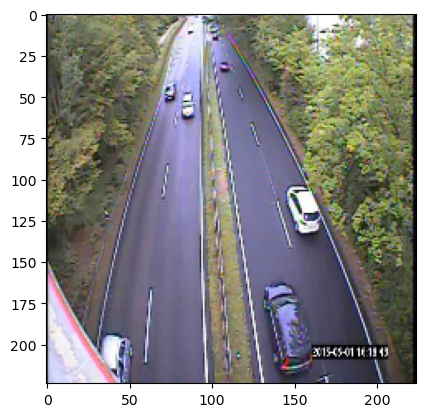

In [44]:

# Run inferences on sample images
def run_inference(model, image):
    prediction = model.predict(np.expand_dims(image, axis=0))[0]
    bbox = prediction[num_labels:]  # Extract bbox from the concatenated output
    scores = prediction[:num_labels]  # Extract scores from the concatenated output
    return bbox, scores

sample_image = X_val[0]
bbox, scores = run_inference(model, sample_image)

index_to_label = {index: label for index, label in enumerate(unique_labels)}

predicted_label = index_to_label[np.argmax(scores)]

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none'))
plt.title(f"Predicted: {predicted_label}")
plt.show()

# Questions:
1. Data Augmentation. We have multiple labels (classes) in one image. How do I do data augmentation without compromising the bounding boxes?
2. Undersampling/Oversampling. How to compensate of those discrepancies in the data? We have classes with 1,837 labels only and other classes with 233,497 labels.
3. The data is split into training and validation but, do we use the same validation data to evaluate the model? Seems we need to split the data in 3 parts...
